In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline 

In [3]:
import os
from glob import glob
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
from scipy.optimize import lsq_linear
from sklearn.linear_model import LinearRegression
import pickle

## Configuration

### Plotting styling

In [4]:
colors = {}
colors['Threshold0'] = 'black'
colors['Threshold'] = 'black'
colors['Mixedbcstc'] = 'black'
colors['AutoEncoderStride'] = 'tab:blue'
colors['AutoEncoderStrideAEMSE'] = 'tab:orange'
colors['AutoEncoderStrideAppMSE'] = 'tab:red'
colors['AutoEncoderStridePairHuber'] = 'tab:green'
colors['AutoEncoderStridePairMSE'] = 'tab:purple'


styles = {}
styles['Threshold0'] = '-'
styles['Threshold'] = '-.'
styles['Mixedbcstc'] = '--'
styles['AutoEncoderStride'] = '-'
styles['AutoEncoderStrideAEMSE'] = '--'
styles['AutoEncoderStrideAppMSE'] = '--'
styles['AutoEncoderStridePairHuber'] = '--'
styles['AutoEncoderStridePairMSE'] = '--'


markers = {}
markers['Threshold0'] = 'o'
markers['Threshold'] = 'o'
markers['Mixedbcstc'] = 'o'
markers['AutoEncoderStride'] = 'o'
markers['AutoEncoderStrideAEMSE'] = 'o'
markers['AutoEncoderStrideAppMSE'] = 'o'
markers['AutoEncoderStridePairHuber'] = 'o'
markers['AutoEncoderStridePairMSE'] = 'o'



legends = {}
legends['Threshold0'] = 'All TC'
legends['Threshold'] = 'Threshold 1.35 mipT'
legends['Mixedbcstc'] = 'BC+STC'
legends['AutoEncoderStride'] = 'Loss: Tele'
legends['AutoEncoderStrideAEMSE'] = 'Loss: AE MSE'
legends['AutoEncoderStrideAppMSE'] = 'Loss: APP MSE'
legends['AutoEncoderStridePairHuber'] = 'Loss: Pair Huber'
legends['AutoEncoderStridePairMSE'] = 'Loss: Pair MSE'

ref_name = 'Threshold0'
plotted_algo = ['Threshold0',
                'Threshold',
                'Mixedbcstc',
                'AutoEncoderStride',
                'AutoEncoderStrideAEMSE',
                'AutoEncoderStrideAppMSE',
                'AutoEncoderStridePairHuber',
                'AutoEncoderStridePairMSE'
               ]

### Input files and FE algorithms to be studied
Both 200PU electron gun and 0PU photon guns are loaded

In [5]:
version = '101801'
fig_dir = 'img/electron_photon_calib_autoencoder_{}'.format(version)
algo_files = {}
# Read  first set
directory = '/home/jovyan/10_18_1/electron_photon_signaldriven/v_1_2021-10-23'

fes = ['Threshold0',
                'Threshold',
                'Mixedbcstc',
                'AutoEncoderStride',
                'AutoEncoderStrideAEMSE',
                'AutoEncoderStrideAppMSE',
                'AutoEncoderStridePairHuber',
                'AutoEncoderStridePairMSE']

for fe in fes:
    algo_files[fe] = (glob(directory+'/electrons/*.hdf5'), glob(directory+'/photons/*.hdf5'))

## Loading and preprocessing dataframes

In [6]:
algos_dfs = {}
for fe,files in algo_files.items():
    name = fe
    dfs = []
    for file in files[0]:
        store = pd.HDFStore(file, mode='r')
        dfs.append(store[name])
        store.close()
    for file in files[1]:
        store = pd.HDFStore(file, mode='r')
        dfs.append(store[name])
        store.close()
    algos_dfs[fe] = pd.concat(dfs)
algo_names = sorted(algos_dfs.keys())

Selection cuts (in addition to those already applied before):
- Gen particle $p_T > 5 GeV$
- Cluster $p_T > 3 GeV$
- Extrapolated gen particle eta between 1.6 and 2.9

Additionally label electrons and positrons as `0` and photons as `1`.

In [7]:
ptcut=5
clptcut=3
etamin=1.6
etamax=2.9
algo_cut={}
for name,df in algos_dfs.items():
    sel = df['genpart_pt']>ptcut
    algo_cut[name] = df[sel]
    sel = algo_cut[name]['cl3d_pt']>clptcut
    algo_cut[name] = algo_cut[name][sel]
    sel = np.abs(algo_cut[name]['genpart_exeta'])>etamin
    algo_cut[name] = algo_cut[name][sel]
    sel = np.abs(algo_cut[name]['genpart_exeta'])<etamax
    algo_cut[name] = algo_cut[name][sel]
    sel = algo_cut[name]['matches']==True
    algo_cut[name] = algo_cut[name][sel]
    #algo_cut[name].dropna(inplace=True)
    algo_cut[name]['genpart_pid'].replace([-11,11],1, inplace=True)
    algo_cut[name]['genpart_pid'].replace([22],0, inplace=True)

In [8]:
for name,df in algo_cut.items():
    df['cl3d_abseta'] = np.abs(df.cl3d_eta)

## Energy corrections
### Layer weights
On 0PU photon clusters:
- Select layer pTs in the ECAL, dropping the first layer as it doesn't bring anything in the e/g energy and is polluted by PU
- Apply linear regression to find multiplicative coeff. to be applied to each layer pT. These coeff. are bounded between 0 and 2 to avoid large correction factors

In [9]:
layer_coeffs = {}
for name,df in algo_cut.items():
    print(name)
    # select layers [2,14]
    select = df.query('genpart_pid==0')
    layers = np.array(select['cl3d_layer_pt'].tolist())[:,2:15]
    regression = lsq_linear(layers, select['genpart_pt'],
                              bounds = (0.,2.0),
                              method='bvls',
                              lsmr_tol='auto',
                              verbose=1)
    layer_coeffs[name] = regression.x
    print(regression.x)

Threshold0
The relative change of the cost function is less than `tol`.
Number of iterations 4, initial cost 5.8389e+04, final cost 4.0795e+04, first-order optimality 8.06e-10.
[2.         0.81663366 1.12115864 1.04568445 0.85426564 1.24767035
 1.00163354 1.06052296 0.90106891 0.86212898 0.92371034 2.
 2.        ]
Threshold
The relative change of the cost function is less than `tol`.
Number of iterations 3, initial cost 5.4681e+04, final cost 4.2743e+04, first-order optimality 3.70e-09.
[2.         0.88037102 1.11596789 1.05861011 0.86859411 1.25543261
 0.98746867 1.09099594 0.89614652 0.89384791 0.96211855 1.89375854
 2.        ]
Mixedbcstc
The relative change of the cost function is less than `tol`.
Number of iterations 4, initial cost 5.8855e+04, final cost 4.8140e+04, first-order optimality 6.81e-09.
[2.         0.72095555 1.24235649 1.02475915 0.8499142  1.6360265
 0.90318639 1.16550112 1.10147615 1.16210616 1.10929527 2.
 2.        ]
AutoEncoderStride
The relative change of the c

Apply layer weights and compute ratios wrt the gen $p_T$ and plot the weight values

In [10]:
# Apply calibration
for name,df in algo_cut.items():
    layers = np.array(df['cl3d_layer_pt'].tolist())[:,2:15]
    df['cl3d_pt_calib'] = np.dot(layers, layer_coeffs[name])
    df['cl3d_over_gen_pt'] = df['cl3d_pt']/df['genpart_pt']
    df['calib_over_gen_pt'] = df['cl3d_pt_calib']/df['genpart_pt']

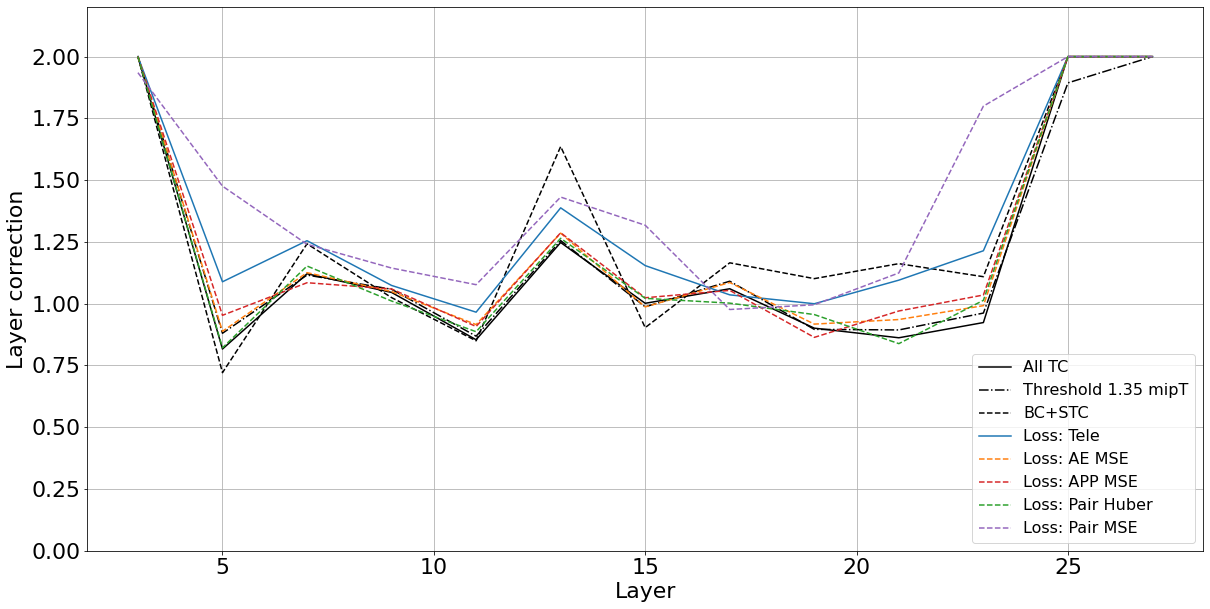

In [11]:
matplotlib.rcParams.update({'font.size': 22})
plt.figure(figsize=(20,10))
for name,weights in layer_coeffs.items():
    plt.plot(range(3, 29, 2), weights, label=legends[name], color=colors[name], ls=styles[name])
plt.ylim(0., 2.2)
plt.legend(fontsize=16)
plt.grid()
plt.xlabel('Layer')
plt.ylabel('Layer correction')
plt.show()

Check impact of layer corrections on the energy ratio distributions

Raw mean=0.9600978493690491, rms=0.03295323625206947, rms/mean=0.03432278936331903
Calib mean=0.9984249442218193, rms=0.041087714211140866, rms/mean=0.0411525317440511


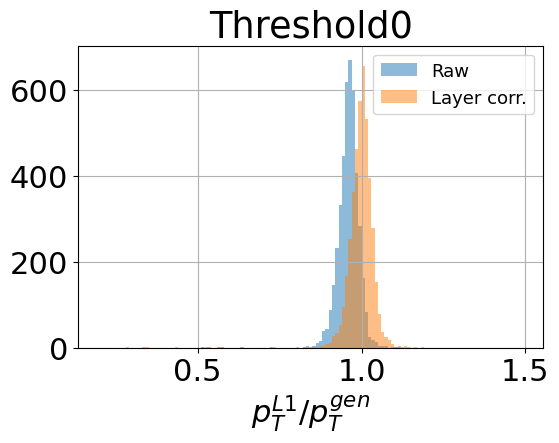

Raw mean=0.9398545026779175, rms=0.03965083509683609, rms/mean=0.04218826955008396
Calib mean=0.9870803605785723, rms=0.046460475986884936, rms/mean=0.047068585134904674


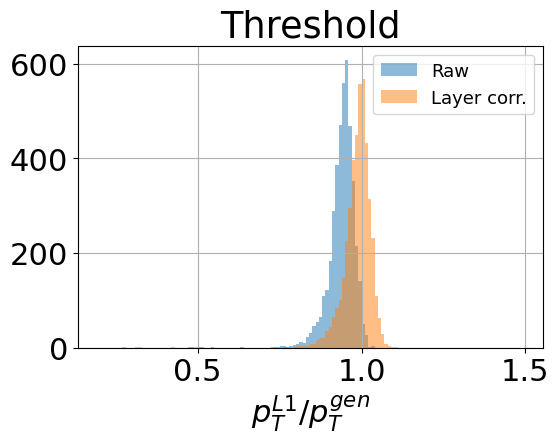

Raw mean=0.8861873745918274, rms=0.035842958837747574, rms/mean=0.04044625308982384
Calib mean=1.0013596736439796, rms=0.044109860042053944, rms/mean=0.044049966463635154


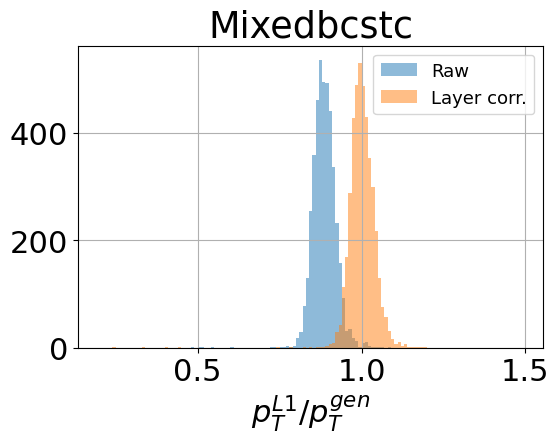

Raw mean=0.8660095930099487, rms=0.041489169001579285, rms/mean=0.04790844043352607
Calib mean=0.9955433501529238, rms=0.05261706279088394, rms/mean=0.05285260835984844


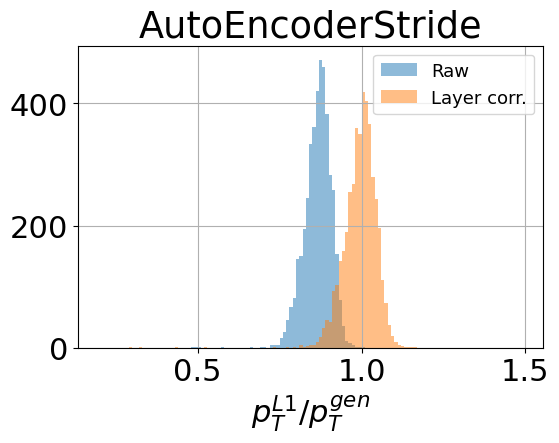

Raw mean=0.9332122802734375, rms=0.034273870289325714, rms/mean=0.03672676733238362
Calib mean=0.9956851290920068, rms=0.042788884884461545, rms/mean=0.04297431349957183


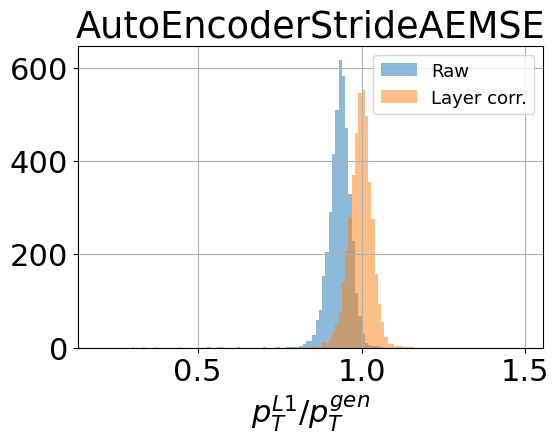

Raw mean=0.9329394698143005, rms=0.03814338892698288, rms/mean=0.040885170111384865
Calib mean=0.9953127326705201, rms=0.046418543594269016, rms/mean=0.046637144357355484


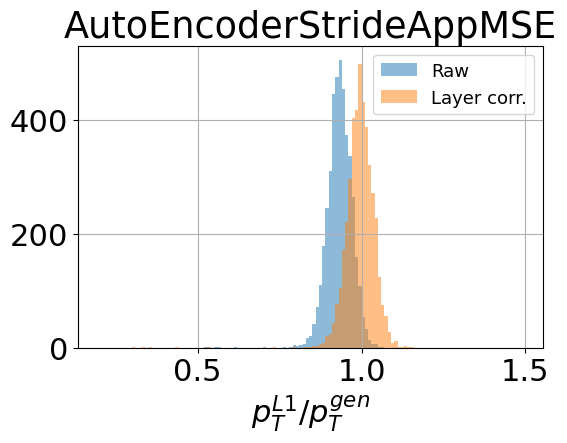

Raw mean=0.9493104815483093, rms=0.03476275876164436, rms/mean=0.036618956007887844
Calib mean=0.9955764850695037, rms=0.04264486043478543, rms/mean=0.04283433877188078


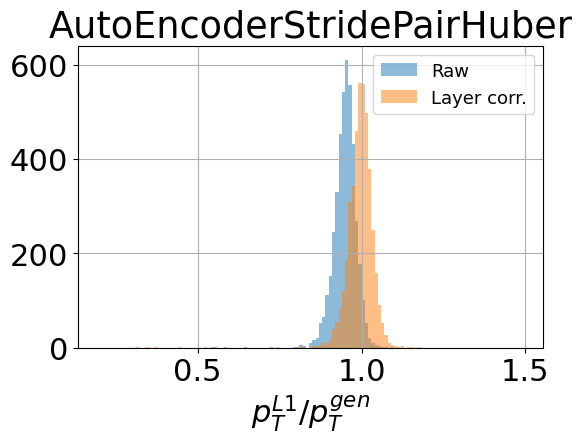

Raw mean=0.8066148161888123, rms=0.06258583813905716, rms/mean=0.0775907370940321
Calib mean=0.9917255208275327, rms=0.08013791212322102, rms/mean=0.08080654419012123


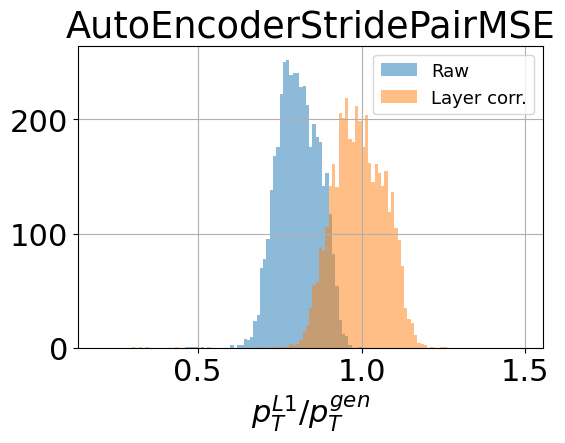

In [12]:
for name,df in algo_cut.items():
    select = df.query('genpart_pid==0')
    print('Raw mean={0}, rms={1}, rms/mean={2}'.format(
        select['cl3d_over_gen_pt'].mean(),
        select['cl3d_over_gen_pt'].std(),
        select['cl3d_over_gen_pt'].std()/select['cl3d_over_gen_pt'].mean()
    ))
    print('Calib mean={0}, rms={1}, rms/mean={2}'.format(
        select['calib_over_gen_pt'].mean(),
        select['calib_over_gen_pt'].std(),
        select['calib_over_gen_pt'].std()/select['calib_over_gen_pt'].mean()
    ))
    
    plt.figure(dpi=100)
    plt.hist(select['cl3d_over_gen_pt'], bins=np.arange(0.2, 1.5, 0.01), alpha=0.5, label='Raw')
    plt.hist(select['calib_over_gen_pt'], bins=np.arange(0.2, 1.5, 0.01), alpha=0.5, label='Layer corr.')
    plt.title(name)
    plt.legend(fontsize=13)
    plt.xlabel(r'$p_{T}^{L1}/p_{T}^{gen}$')
    plt.grid()
    plt.show()

## eta correction
On 200PU electrons, on top of the layer correction.

Simple linear correction vs eta to correct for PU. This correction is additive, not multiplicative.

In [13]:
corrs = {}
corrs['eta'] = {}
for name,df in algo_cut.items():
    print('  '+name)
    select = df.query('genpart_pid==1')
    X = select[['cl3d_abseta']]
    y = select['genpart_pt']-select['cl3d_pt_calib']
    corrs['eta'][name] = LinearRegression().fit(X, y)

  Threshold0
  Threshold
  Mixedbcstc
  AutoEncoderStride
  AutoEncoderStrideAEMSE
  AutoEncoderStrideAppMSE
  AutoEncoderStridePairHuber
  AutoEncoderStridePairMSE


Print correction value at eta=1.5 and eta=3

In [14]:
for name,df in algo_cut.items():
    corr = corrs['eta'][name]
    print(name)
    print('  eta=1.5:', corr.intercept_+corr.coef_*1.5)
    print('  eta=3:', corr.intercept_+corr.coef_*3)

Threshold0
  eta=1.5: [3.8082829]
  eta=3: [-9.738529]
Threshold
  eta=1.5: [3.5525885]
  eta=3: [-9.349472]
Mixedbcstc
  eta=1.5: [4.8343906]
  eta=3: [-3.540307]
AutoEncoderStride
  eta=1.5: [4.004879]
  eta=3: [-16.116596]
AutoEncoderStrideAEMSE
  eta=1.5: [3.962061]
  eta=3: [-17.291107]
AutoEncoderStrideAppMSE
  eta=1.5: [3.6254444]
  eta=3: [-16.66965]
AutoEncoderStridePairHuber
  eta=1.5: [4.107443]
  eta=3: [-19.172201]
AutoEncoderStridePairMSE
  eta=1.5: [3.1963902]
  eta=3: [-16.716928]


In [15]:
for name,df in algo_cut.items():
    df['cl3d_corr_eta'] = corrs['eta'][name].predict(df[['cl3d_abseta']])
    df['cl3d_pt_corr_eta'] =  df['cl3d_corr_eta']+df.cl3d_pt_calib
    df['corr_eta_over_gen_pt'] = df['cl3d_pt_corr_eta']/df['genpart_pt']    

Raw mean=0.9979511499404907, rms=0.12168502807617188, rms/mean=0.12193485430968051
Calib mean=1.0415668923359997, rms=0.10961874552874876, rms/mean=0.10524407633858121
Corr eta mean=0.9961287043131888, rms=0.06786729624178835, rms/mean=0.06813105168832728


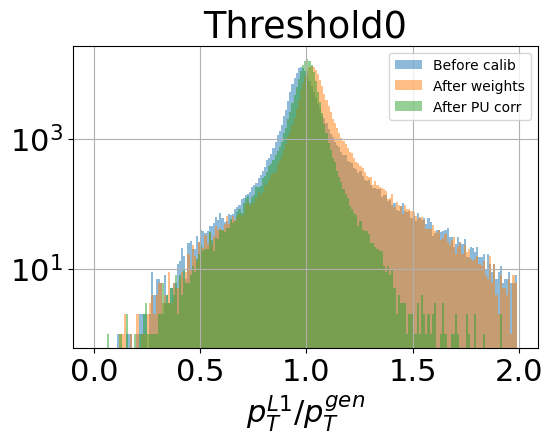

Raw mean=0.9695566892623901, rms=0.09916607290506363, rms/mean=0.10227980890989079
Calib mean=1.0328894121739416, rms=0.10003144107040111, rms/mean=0.09684622563790549
Corr eta mean=0.9884310813651571, rms=0.07408765950100121, rms/mean=0.07495480554767271


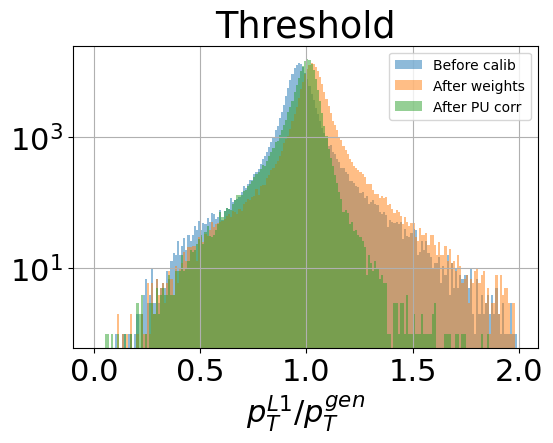

Raw mean=0.8992560505867004, rms=0.08634187281131744, rms/mean=0.09601478105705881
Calib mean=0.9911477197905729, rms=0.07939154902800806, rms/mean=0.08010062218049929
Corr eta mean=1.0022363170706958, rms=0.06776208221532738, rms/mean=0.06761088284385884


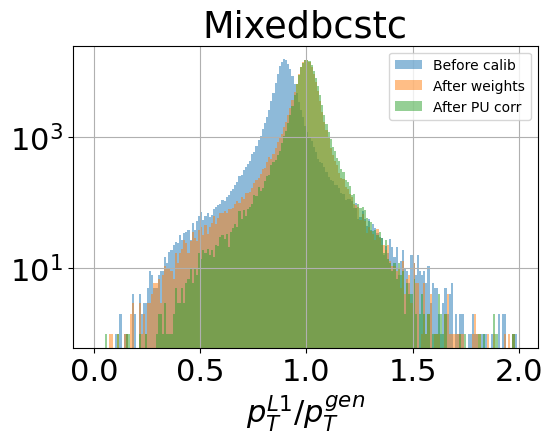

Raw mean=0.9296918511390686, rms=0.131084144115448, rms/mean=0.14099741108286823
Calib mean=1.078816683560024, rms=0.1366832683434903, rms/mean=0.12669739949927777
Corr eta mean=0.9853556186311848, rms=0.08953469340240182, rms/mean=0.0908653603932149


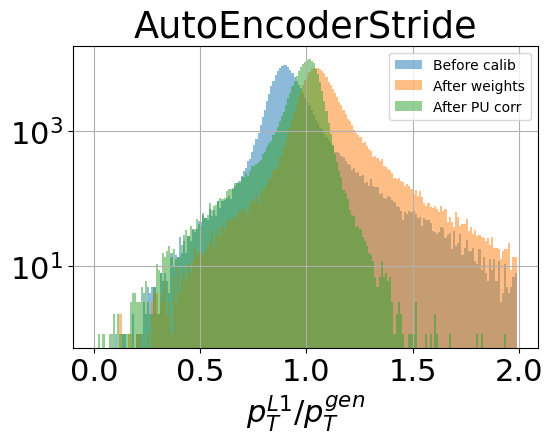

Raw mean=1.01071298122406, rms=0.14125579595565796, rms/mean=0.13975856507213857
Calib mean=1.0858166167795038, rms=0.1373170528004797, rms/mean=0.12646431329054214
Corr eta mean=0.9827703819194334, rms=0.09026220335059797, rms/mean=0.09184465162076647


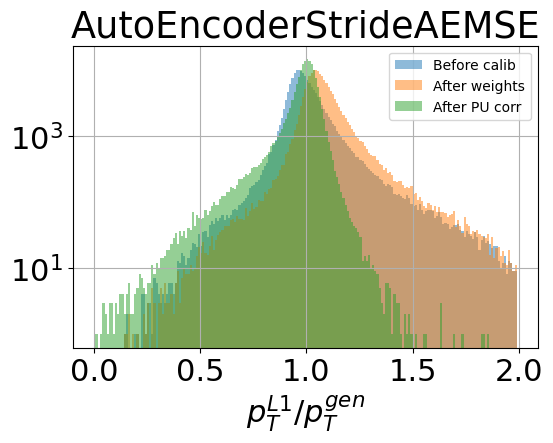

Raw mean=1.0070507526397705, rms=0.13826484978199005, rms/mean=0.13729680397890373
Calib mean=1.0835529366536942, rms=0.13453873087643728, rms/mean=0.1241644282668177
Corr eta mean=0.9826450474123511, rms=0.09144147911994478, rms/mean=0.093056469740261


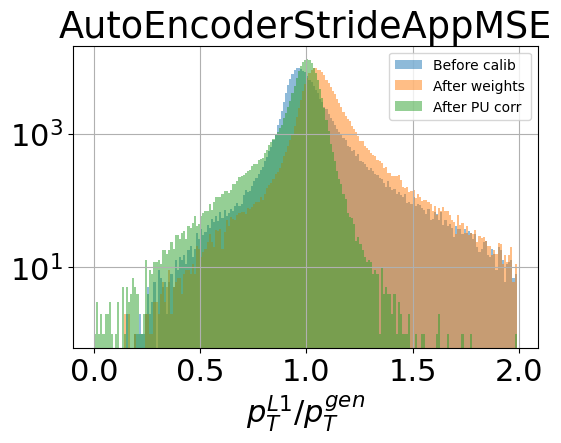

Raw mean=1.038739800453186, rms=0.15337631106376648, rms/mean=0.14765614160240204
Calib mean=1.0973166041068656, rms=0.14818665823264252, rms/mean=0.1350445784544156
Corr eta mean=0.9807319842221233, rms=0.09752572529725954, rms/mean=0.09944177090809675


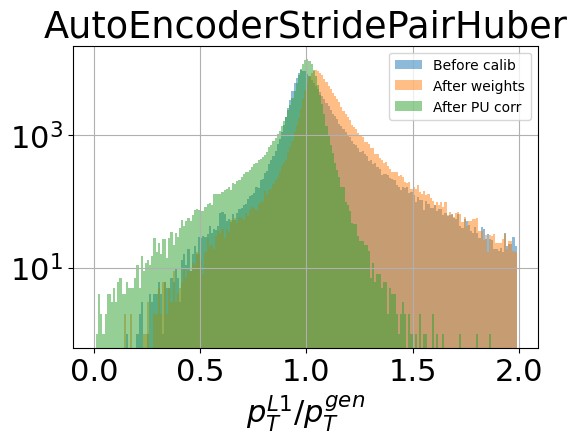

Raw mean=0.8738137483596802, rms=0.13862867653369904, rms/mean=0.1586478546417154
Calib mean=1.0906348585564702, rms=0.1583661651599765, rms/mean=0.1452054864352905
Corr eta mean=0.985895786323005, rms=0.10634245427229162, rms/mean=0.10786378818891826


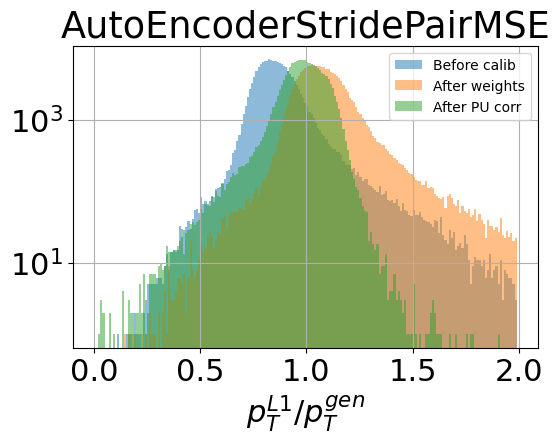

In [16]:
for name,df in algo_cut.items():
    select = df.query('genpart_pid==1 and genpart_pt>10')
    print('Raw mean={0}, rms={1}, rms/mean={2}'.format(
        select['cl3d_over_gen_pt'].mean(),
        select['cl3d_over_gen_pt'].std(),
        select['cl3d_over_gen_pt'].std()/select['cl3d_over_gen_pt'].mean()
    ))
    print('Calib mean={0}, rms={1}, rms/mean={2}'.format(
        select['calib_over_gen_pt'].mean(),
        select['calib_over_gen_pt'].std(),
        select['calib_over_gen_pt'].std()/select['calib_over_gen_pt'].mean()
    ))
    print('Corr eta mean={0}, rms={1}, rms/mean={2}'.format(
        select['corr_eta_over_gen_pt'].mean(),
        select['corr_eta_over_gen_pt'].std(),
        select['corr_eta_over_gen_pt'].std()/select['corr_eta_over_gen_pt'].mean()
    ))
    #plt.figure(figsize=(15,10))
    plt.figure(dpi=100)
    plt.hist(select['cl3d_over_gen_pt'], bins=np.arange(0., 2., 0.01), alpha=0.5, label='Before calib')
    plt.hist(select['calib_over_gen_pt'], bins=np.arange(0., 2., 0.01), alpha=0.5, label='After weights')
    plt.hist(select['corr_eta_over_gen_pt'], bins=np.arange(0., 2., 0.01), alpha=0.5, label='After PU corr')
    plt.grid()
    plt.legend(loc = 'upper right', fontsize=10)
    plt.yscale('log')
    plt.title(name)
    plt.xlabel(r'$p_{T}^{L1}/p_{T}^{gen}$')
    plt.show()

## Final plots
For electrons with 200PU, looking at $p_T > 10\,GeV$
First bin in eta and pT

In [17]:
binetasize = 0.1
binptsize = 5
for name,df in algo_cut.items():
    df['genpart_abseta'] = np.abs(df.genpart_exeta)
    df['genpart_bineta'] = ((df.genpart_abseta - etamin)/binetasize).astype('int32')
    df['genpart_binpt'] = (df.genpart_pt/binptsize).astype('int32')

Compute the mean, RMS, and effective RMS of the pT ratios in each eta and pT bin

In [18]:
def effrms(df, c=0.68):
    """Compute half-width of the shortest interval
    containing a fraction 'c' of items in a 1D array.
    """
    out = {}
    for col in df:
        x = df[col]
        x = np.sort(x, kind="mergesort")
        m = int(c * len(x)) + 1
        out[col] = [np.min(x[m:] - x[:-m]) / 2.0]
    return pd.DataFrame(out).iloc[0]

In [19]:
etameans = {} 
etarmss = {} 
etaeffrmss = {} 
ptmeans = {} 
ptrmss = {} 
pteffrmss = {} 
plot_var = ['genpart_pt', 'genpart_abseta',
            'genpart_bineta', 'genpart_binpt',
           'cl3d_pt', 'cl3d_abseta', 'cl3d_pt_calib',
           'cl3d_pt_corr_eta', 'cl3d_over_gen_pt',
           'calib_over_gen_pt', 'corr_eta_over_gen_pt']
for name,df in algo_cut.items():
    select = df.query('genpart_pid==1 and genpart_pt>10')
    etameans[name] = select[plot_var].groupby('genpart_bineta').mean()
    etarmss[name] = select[plot_var].groupby('genpart_bineta').std()
    etaeffrmss[name] = select[plot_var].groupby('genpart_bineta').apply(effrms)
    ptmeans[name] = select[plot_var].groupby('genpart_binpt').mean()
    ptrmss[name] = select[plot_var].groupby('genpart_binpt').std()
    pteffrmss[name] = select[plot_var].groupby('genpart_binpt').apply(effrms)
    #print(etarmss[name])

Mean vs eta


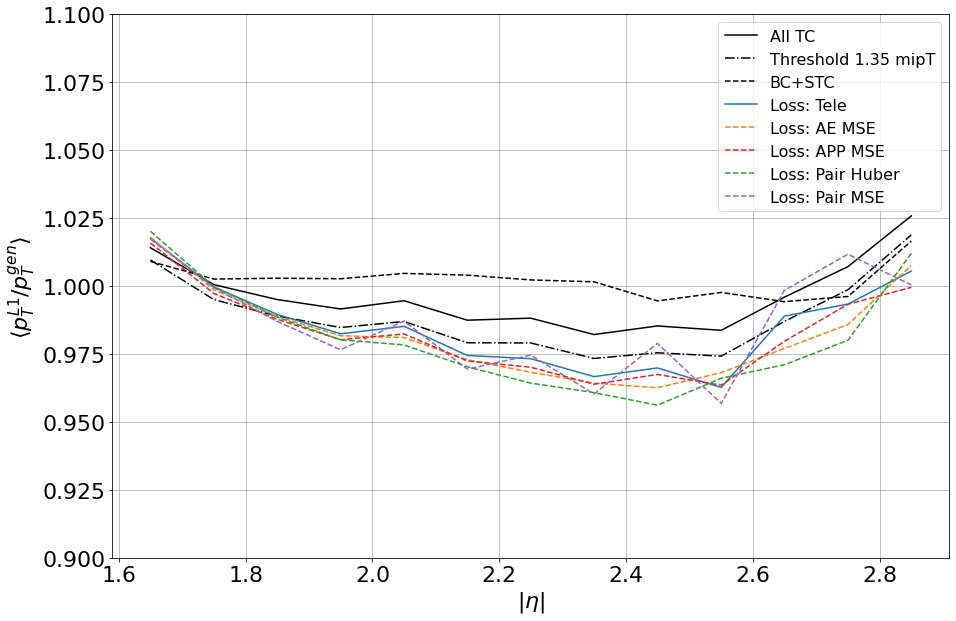

RMS vs eta


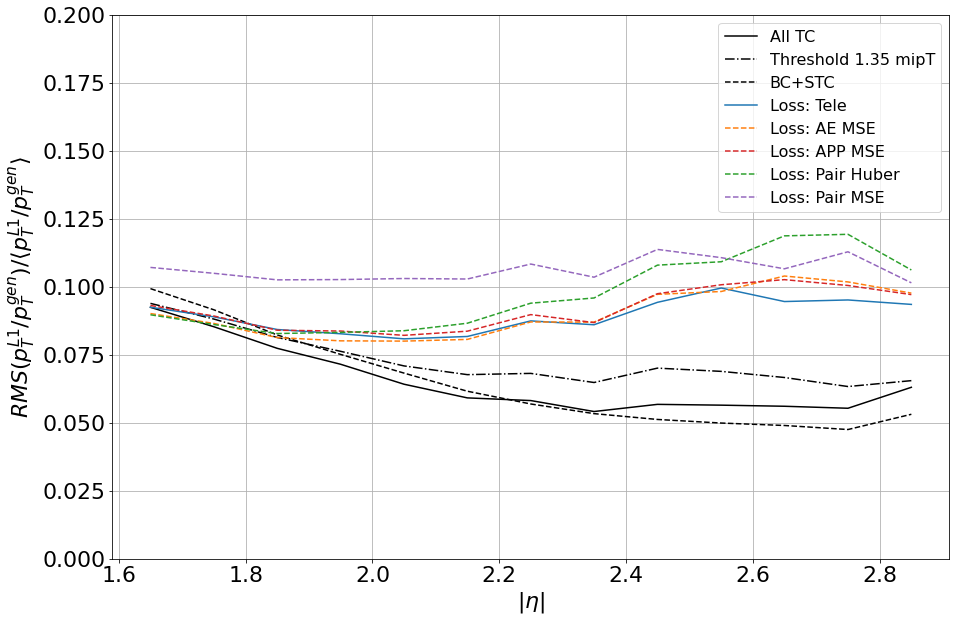

Eff RMS vs eta


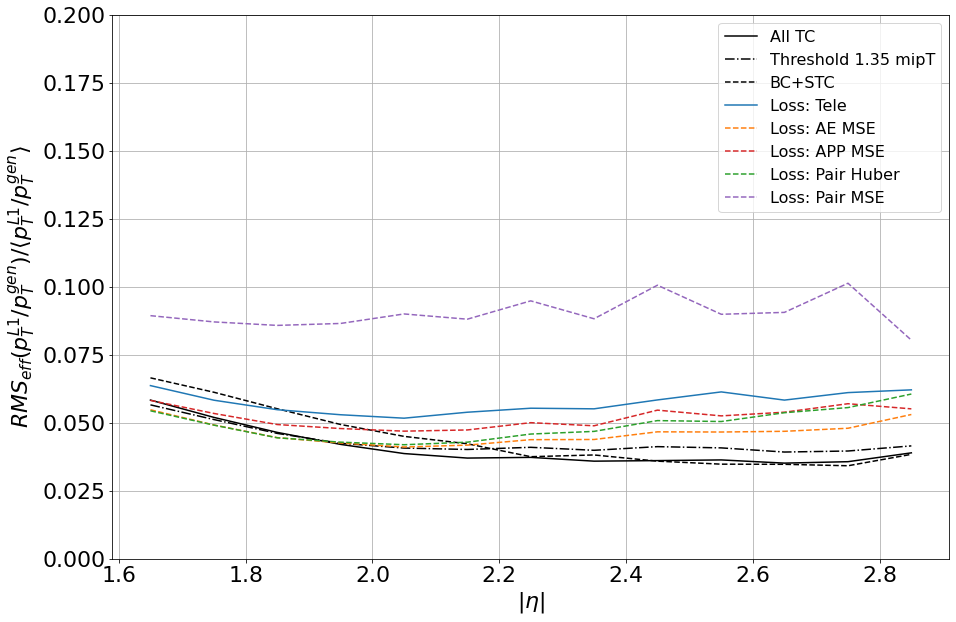

Mean vs pt


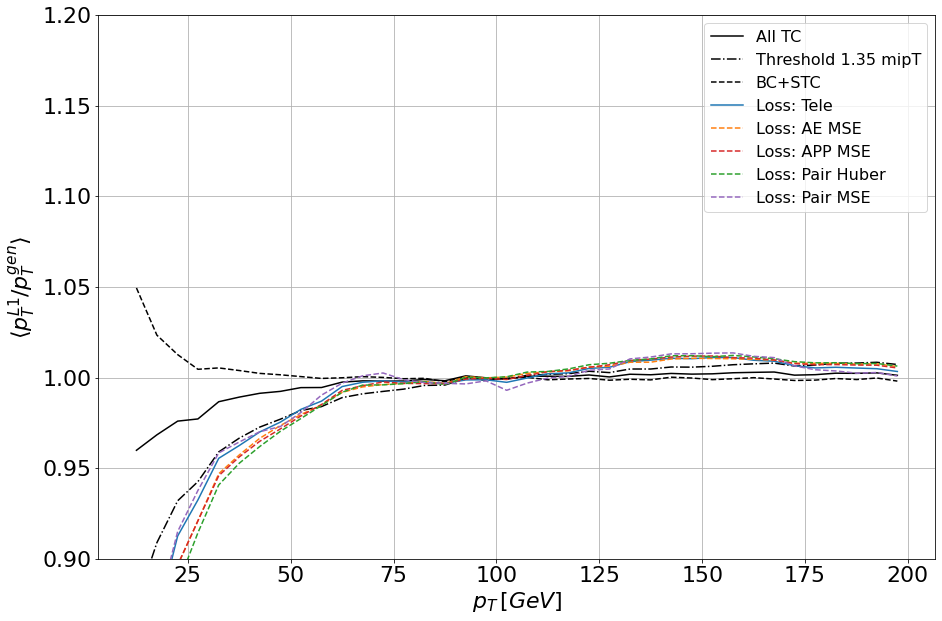

RMS vs pt


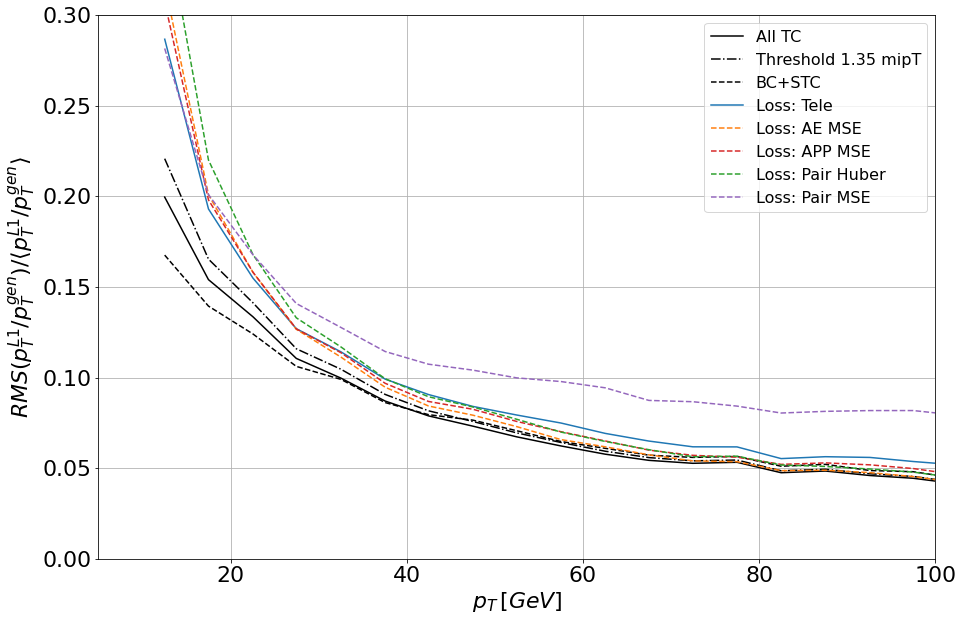

Eff RMS vs pt


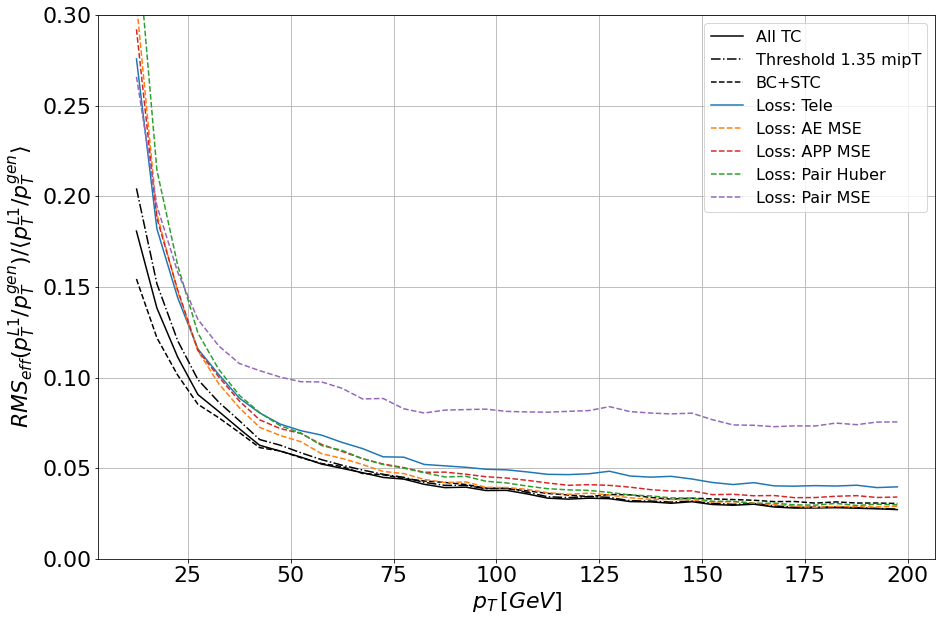

In [20]:
print('Mean vs eta')
plt.figure(figsize=(15,10))
for name in plotted_algo:
    df = etameans[name]
    plt.plot(df['genpart_abseta'], df['corr_eta_over_gen_pt'], color=colors[name], ls=styles[name], label=legends[name])
plt.ylim(0.9, 1.1)
plt.legend(loc = 'upper right', fontsize=16)
plt.xlabel(r'$|\eta|$')
plt.ylabel(r'$\langle p_{T}^{L1}/p_{T}^{gen}\rangle$')
plt.grid()
plt.show()
print('RMS vs eta')
plt.figure(figsize=(15,10))
for name in plotted_algo:
    df = etameans[name]
    plt.plot(df['genpart_abseta'], etarmss[name]['corr_eta_over_gen_pt']/df['corr_eta_over_gen_pt'], color=colors[name], ls=styles[name], label=legends[name])
plt.ylim(0., 0.2)
plt.legend(loc = 'upper right', fontsize=16)
plt.xlabel(r'$|\eta|$')
plt.ylabel(r'$RMS(p_{T}^{L1}/p_{T}^{gen}) / \langle p_{T}^{L1}/p_{T}^{gen}\rangle$')
plt.grid()
plt.show()
print('Eff RMS vs eta')
plt.figure(figsize=(15,10))
for name in plotted_algo:
    df = etameans[name]
    plt.plot(df['genpart_abseta'], etaeffrmss[name]['corr_eta_over_gen_pt']/df['corr_eta_over_gen_pt'], color=colors[name], ls=styles[name], label=legends[name])
plt.ylim(0., 0.2)
plt.legend(loc = 'upper right', fontsize=16)
plt.xlabel(r'$|\eta|$')
plt.ylabel(r'$RMS_{eff}(p_{T}^{L1}/p_{T}^{gen}) / \langle p_{T}^{L1}/p_{T}^{gen}\rangle$')
plt.grid()
plt.show()
print('Mean vs pt')
plt.figure(figsize=(15,10))
for name in plotted_algo:
    df = ptmeans[name]
    plt.plot(df['genpart_pt'], df['corr_eta_over_gen_pt'], color=colors[name], ls=styles[name], label=legends[name])
plt.ylim(0.9, 1.2)
plt.legend(loc = 'upper right', fontsize=16)
plt.xlabel(r'$p_{T}\, [GeV]$')
plt.ylabel(r'$\langle p_{T}^{L1}/p_{T}^{gen}\rangle$')
plt.grid()
plt.show()
print('RMS vs pt')
plt.figure(figsize=(15,10))
for name in plotted_algo:
    df = ptmeans[name]
    plt.plot(df['genpart_pt'], ptrmss[name]['corr_eta_over_gen_pt']/df['corr_eta_over_gen_pt'], color=colors[name], ls=styles[name], label=legends[name])
plt.ylim(0., 0.3)
plt.xlim(5., 100)
plt.legend(loc = 'upper right', fontsize=16)
plt.xlabel(r'$p_{T}\, [GeV]$')
plt.ylabel(r'$RMS(p_{T}^{L1}/p_{T}^{gen}) / \langle p_{T}^{L1}/p_{T}^{gen}\rangle$')
plt.grid()
plt.show()
print('Eff RMS vs pt')
plt.figure(figsize=(15,10))
for name in plotted_algo:
    df = ptmeans[name]
    plt.plot(df['genpart_pt'], pteffrmss[name]['corr_eta_over_gen_pt']/df['corr_eta_over_gen_pt'], color=colors[name], ls=styles[name], label=legends[name])
plt.ylim(0., 0.3)
plt.legend(loc = 'upper right', fontsize=16)
plt.xlabel(r'$p_{T}\, [GeV]$')
plt.ylabel(r'$RMS_{eff}(p_{T}^{L1}/p_{T}^{gen}) / \langle p_{T}^{L1}/p_{T}^{gen}\rangle$')
plt.grid()
plt.show()

## Storing layer weights and eta corrections for external use

In [21]:
with open('data/layer_weights_photons_autoencoder_{}.pkl'.format(version), 'wb') as f:
    pickle.dump(layer_coeffs, f)
    # add  protocol=2 if needed later for python2 in cmssw
with open('data/lineareta_electrons_autoencoder_{}.pkl'.format(version), 'wb') as f:
    pickle.dump(corrs['eta'], f)